### Monitoring an LLM Powered Chatbot

Ensure all steps in [00_setup.ipynb](./00_setup.ipynb) have been completed.  

In this notebook:
- Implement Prompt Shielding to thwart potential adveseries inline with your chat prompting and responses. Check for attacks as they are happening
- Deploy the chat to an Azure Machine Learning Managed Endpoint
- Test our deployment with live
- View deployment metrics/statistics and create a dashboard to easily monitor/share

In [ ]:
#Import required libraries
from azure.ai.ml import MLClient
from dotenv import load_dotenv, find_dotenv
import os
import subprocess
import requests

from promptflow.azure import PFClient
from promptflow.entities import Run
from azure.identity import DefaultAzureCredential
import os

### Add Prompt Shield to the Chatbot

- Navigate to the Azure Portal and Create a (free) Content Safety resource 
- After the resource has been created, add the endpoint and key to your .env file with the variable names **CONTENT_SAFE_BASE** and **CONTENT_SAFE_KEY** respectively
 
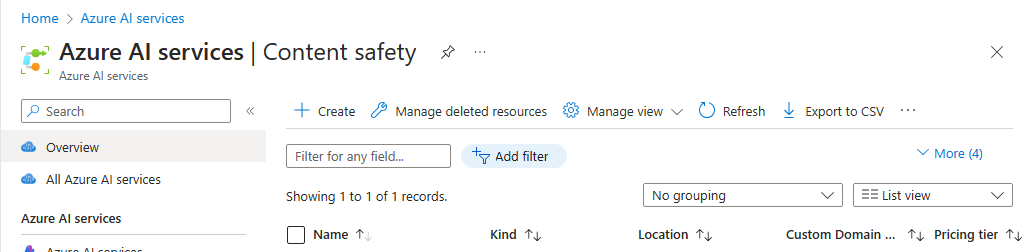

In [ ]:
# Load env variables
load_dotenv(find_dotenv(), override=True)
print(os.getenv('CONTENT_SAFE_BASE'))

Write component to implement prompt shielding

In [ ]:
%%writefile ./src/chat/chat_rag_wiki/prompt_shield.py

from promptflow.core import tool
import requests
import os


@tool
def prompt_shield(prompt: str, context: str):
    # Send a request to the URL
    url = f"{os.environ.get('CONTENT_SAFE_BASE')}contentsafety/text:shieldPrompt?api-version=2024-02-15-preview"
    try:
        headers = {
                "Ocp-Apim-Subscription-Key": os.environ.get("CONTENT_SAFE_KEY"),
                "Content-Type": "application/json",
                }
        
        body = {
                "userPrompt": prompt,
                "documents": [context]
                }
        
        response = requests.post(url=url, headers=headers, json=body)
        promptAttackDetected = response.json()["userPromptAnalysis"]['attackDetected']

        return promptAttackDetected
    
    except Exception as e:
        print("Get url failed with error: {}".format(e))
        return
    

if __name__ == "__main__":
    prompt_shield("What is the capital of France?", "Paris")

### Add RAGAS Faithfulness to chatbot flow  
  
  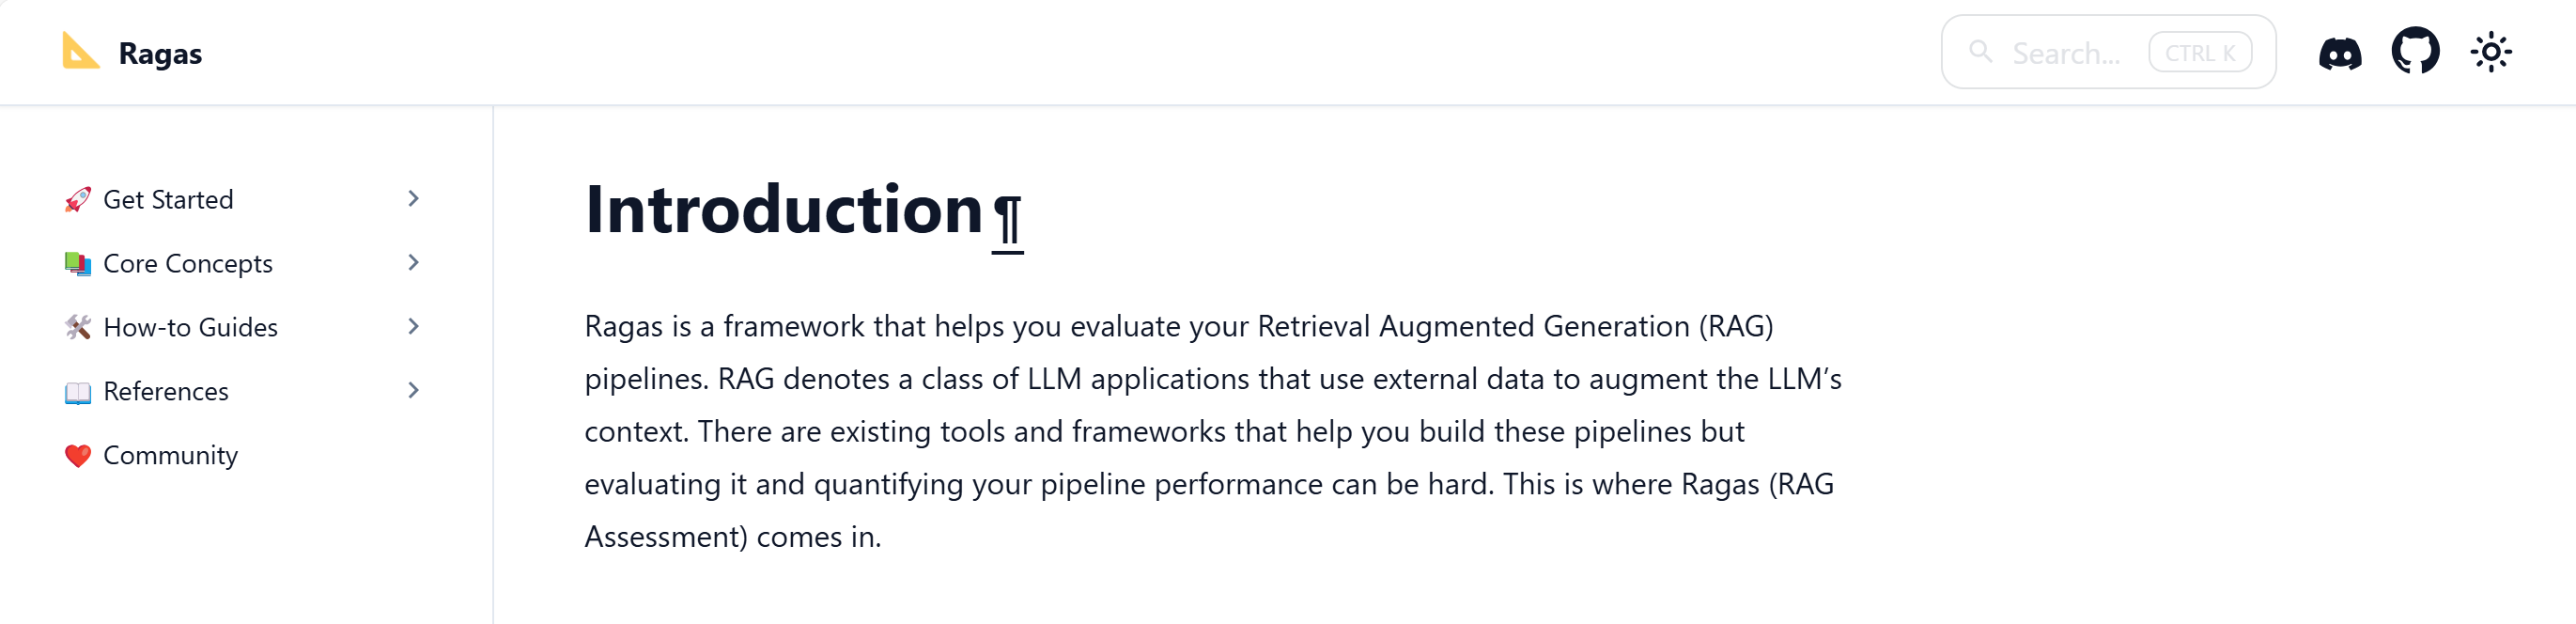

Write component to implement RAGAS faithfulness metric

In [ ]:
%%writefile ./src/chat/chat_rag_wiki/ragas_faith.py

import os
from promptflow.core import tool
from datasets import Dataset 
from ragas.metrics import faithfulness
from ragas import evaluate
from langchain_openai.chat_models import AzureChatOpenAI
from dotenv import load_dotenv, find_dotenv

@tool
def ragas_faithfulness(prompt: str, context: str, response: str):
    
    data_samples = {
    'question': [prompt],
    'answer': [response],
    'contexts' : [context.split(".")],
    }
    dataset = Dataset.from_dict(data_samples)
    
    azure_model = AzureChatOpenAI(
        openai_api_version="2023-05-15",
        azure_endpoint=os.environ.get('AZURE_OPENAI_ENDPOINT'),
        azure_deployment=os.environ.get('AZURE_OPENAI_DEPLOYMENT_NAME'),
        model="gpt-4",
        validate_base_url=False,
    )

    score = evaluate(dataset, llm=azure_model, metrics=[faithfulness])

    return score
    

if __name__ == "__main__":
    load_dotenv(find_dotenv(), override=True)
    score = ragas_faithfulness(
                prompt = "Who was the second president of the United States?",
                context = "John Adams was the second president. John Adams was the Uncle of John Quincy Adams",
                response = "Ben Franklin was the 2nd president."
                )
    print(score)


Check out the components in [the flow](./src/promptflows/chat_rag_wiki/flow.dag.yaml) (this has been implemented for you).   
  
Then, test run against our [sample data](./src/evaluation/input_test_data.csv)  
  
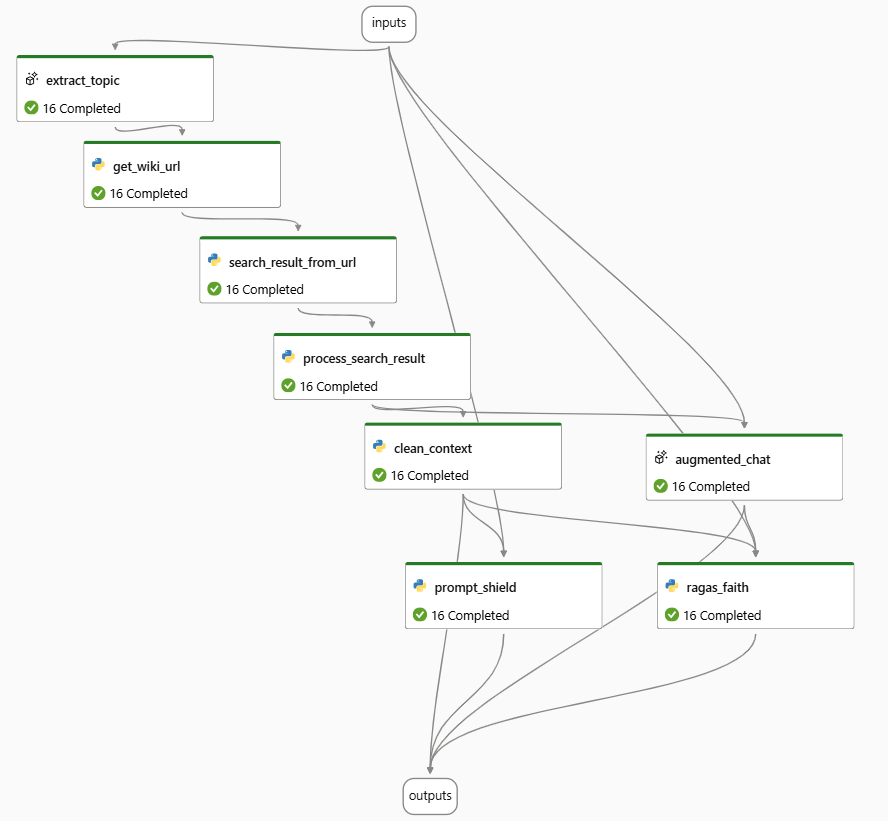

In [ ]:
pf = PFClient(credential=DefaultAzureCredential(),
            subscription_id=os.environ.get('SUBSCRIPTION_ID'),
            resource_group_name=os.environ.get('RESOURCE_GROUP_NAME'),
            workspace_name=os.environ.get('WORKSPACE_NAME')
            )

# Define Flows and Data
chat_flow = "./src/chat/chat_rag_wiki" # set the flow directory
eval_flow = "./src/evaluation/eval_flow" # set flow directory
data = "./src/evaluation/input_test_data.csv" # set the data file

# Define remote compute instance (serverless)
resources = {"instance_type": "Standard_D2"}

##### Run chat flow #########
chat_run = Run(
    display_name="Chat RAG Wiki Run",
    flow=chat_flow,
    data=data,
    resources=resources,
    column_mapping={  # map the url field from the data to the url input of the flow
    "input": "${data.input}",
    },
    environment_variables={
    "CONTENT_SAFE_BASE": os.environ.get('CONTENT_SAFE_BASE'),
    "CONTENT_SAFE_KEY": os.environ.get('CONTENT_SAFE_KEY'),
    "AZURE_OPENAI_API_KEY": os.environ.get('AZURE_OPENAI_API_KEY'),
    "AZURE_OPENAI_ENDPOINT": os.environ.get('AZURE_OPENAI_ENDPOINT'),
    "AZURE_OPENAI_DEPLOYMENT_NAME": os.environ.get('AZURE_OPENAI_DEPLOYMENT_NAME')
    }
)

chat_run_job = pf.runs.create_or_update(run=chat_run)

pf.runs.stream(chat_run_job)

In [13]:
print(os.environ.get('AZURE_OPENAI_KEY'))

None


In [ ]:
# View run outputs 
pf.runs.get_details(chat_run_job)

Via the Azure Machine Learning Studio - we can see that our inline PromptShield implementation only adds ~145ms to our chatbots response time. The Ragas component takes significantly more time. But still may be useful in a batch setting.
  
  !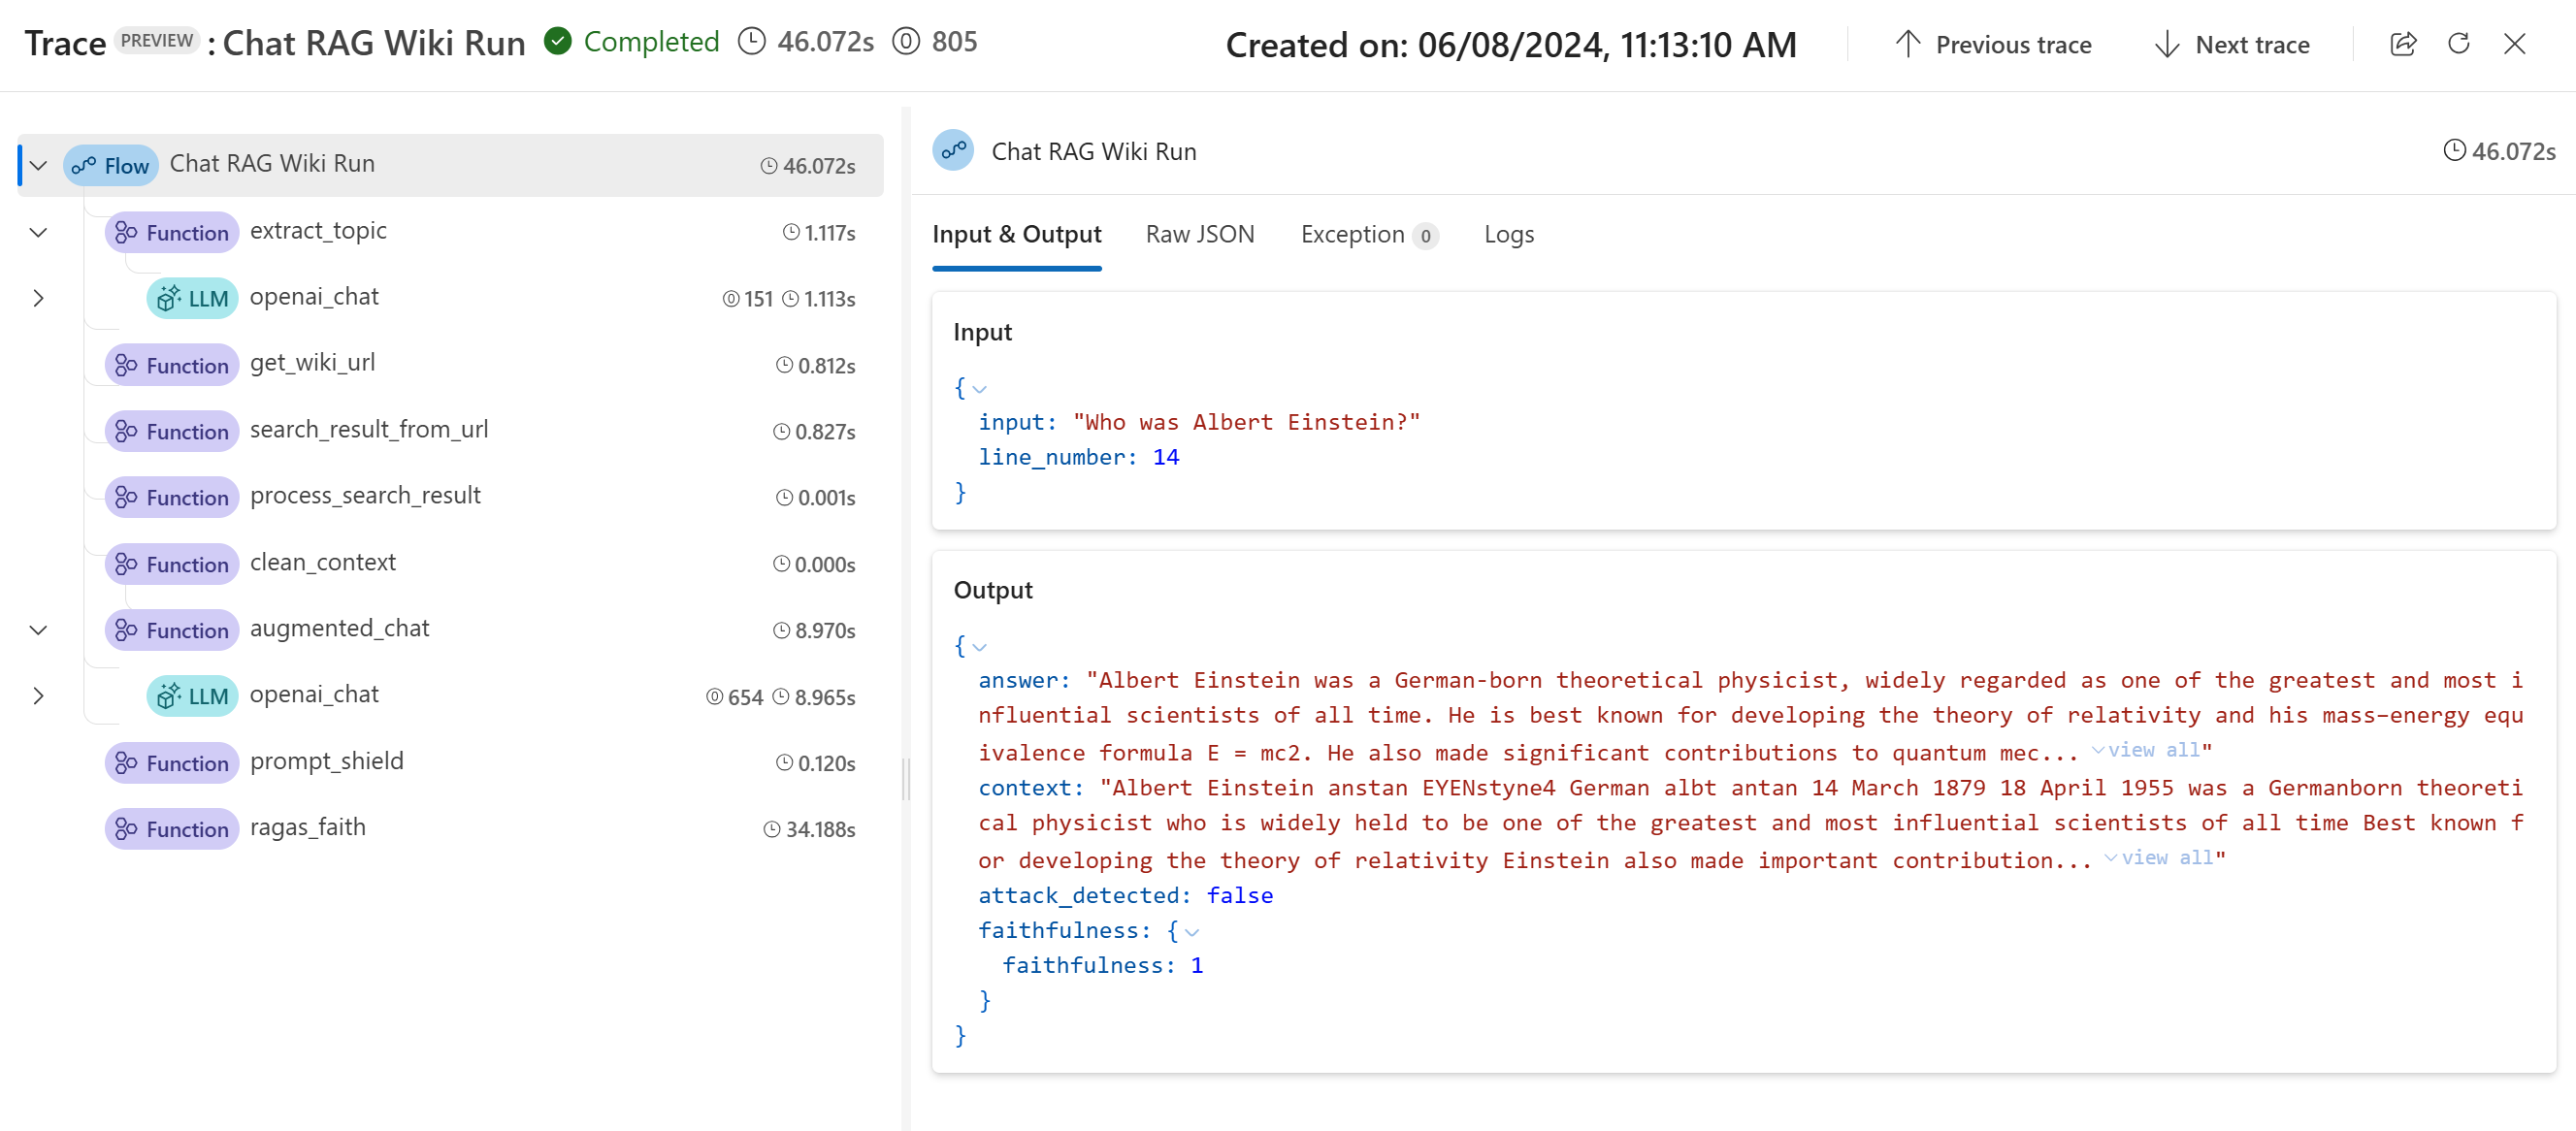


### Deploy Chatbot Model to managed Endpoint

In [ ]:
# Set CLI defaults

subscription_id = os.environ.get('SUBSCRIPTION_ID')
resource_group = os.environ.get('RESOURCE_GROUP_NAME')
workspace_name = os.environ.get('WORKSPACE_NAME')

command1 = f"az account set --subscription {subscription_id}"
result = subprocess.run(command1, shell=True, check=True, text=True, capture_output=True)
print(result.stdout)


command2 = f"az configure --defaults workspace={workspace_name} group={resource_group}"
result = subprocess.run(command2, shell=True, check=True, text=True, capture_output=True)
print(result.stdout)

In [ ]:
# Register PF as a model

command3 = "az ml model create --file ./src/deployment_scripts/register_model.yml"
result = subprocess.run(command3, shell=True, check=True, text=True, capture_output=True)
print(result.stdout)

Confirm a model has been registered in your AML workspace  
  
  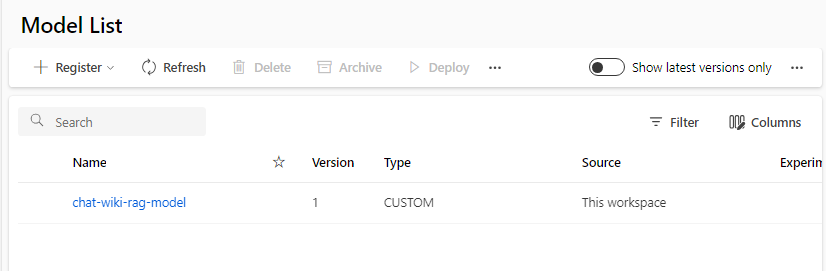

In [ ]:
# Create managed online endpoint

command4 = "az ml online-endpoint create --file ./src/deployment_scripts/endpoint.yml"
result = subprocess.run(command4, shell=True, check=True, text=True, capture_output=True)
print(result.stdout)

In [ ]:
# Create Deployment
# Note - this may take some time

# Config override for PF environment variable
config_override = f"deployment.subscription_id={subscription_id},deployment.resource_group={resource_group},deployment.workspace_name={workspace_name},deployment.endpoint_name=chat-endpoint,deployment.deployment_name=blue"

command5 = f"az ml online-deployment create --file ./src/deployment_scripts/deployment.yml --all-traffic \
            --set environment_variables.CONTENT_SAFE_BASE={os.environ.get('CONTENT_SAFE_BASE')} \
                  environment_variables.CONTENT_SAFE_KEY={os.environ.get('CONTENT_SAFE_KEY')} \
                  environment_vatiables.AZURE_OPENAI_ENDPOINT={os.environ.get('AZURE_OPENAI_ENDPOINT')} \
                  environment_variables.AZURE_OPENAI_API_KEY={os.environ.get('AZURE_OPENAI_API_KEY')} \
                  environment_variables.AZURE_OPENAI_DEPLOYMENT_NAME={os.environ.get('AZURE_OPENAI_DEPLOYMENT_NAME')} \
                  environment_variables.PRT_CONFIG_OVERRIDE={config_override}"

result = subprocess.run(command5, shell=True, check=True, text=True, capture_output=True)
print(result.stdout)


### Test Deployment

From the Azure Portal navigate to your Azure Machine Learning Workspace. Go to Endpoints --> chat-endpoint --> Consume  
Paste the URL and the Key into the cell below to test your chatbot

In [ ]:
input = {"input": "What is the ellis island?"}

url = "" # ADD YOUR ENDPOINT URL HERE
key = "" # ADD YOUR ENDPOINT KEY HERE
headers = {
        "Authorization": f"Bearer {key}",
        "Content-Type": "application/json",
        }

response = requests.post(url=url, headers=headers, json=input)
print(response.json())

### View Metrics

Via the Azure Portal, navigate to Monitor --> View Metrics --> select your deployment resource within AML --> apply  
  
From here you can create visualizations that track deployment statistics in near real time. You can track Number or Requests, CPU/RAM Utilization, Latency, and more. Then, you can add these statistics to Dashboards for live, shareable tracking. Like so:
  
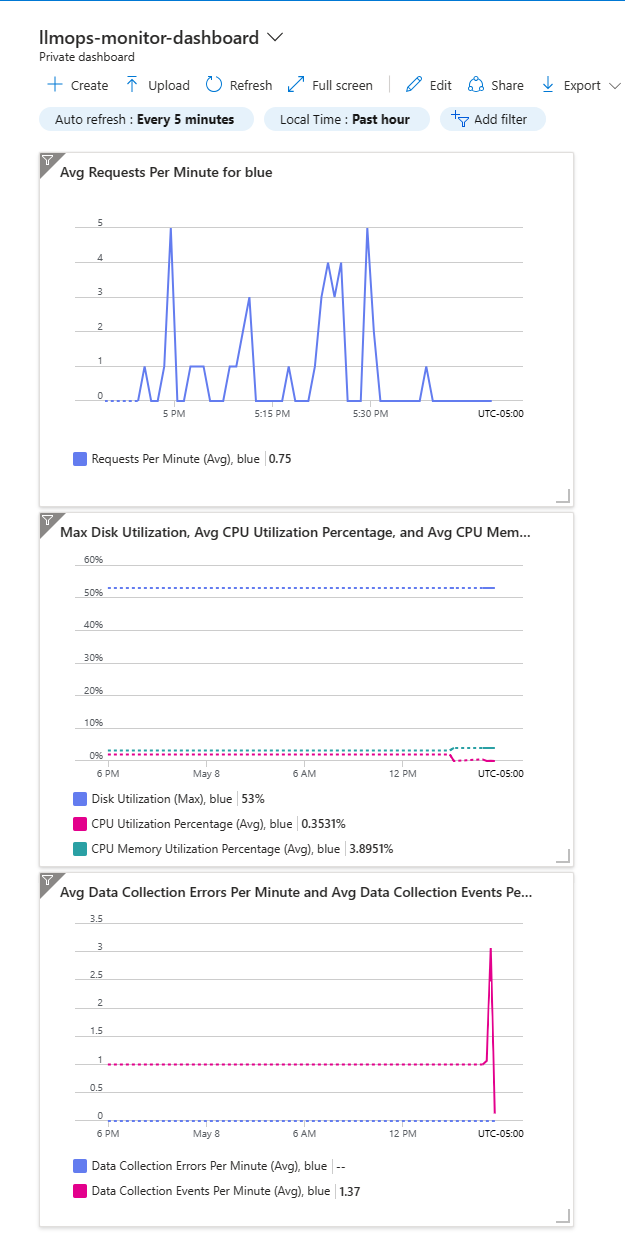